In [1]:
##############################
## 鲁棒模型验证，cost parameter 和 value paramter 设置为可配置的
## 求解器MOSEK需要申请免费license https://www.mosek.com/try/
##############################
import cvxpy as cp
import numpy as np
import scipy.stats as stats
import math
import matplotlib.pyplot as plt

In [22]:
##############################
## 数据生成
##############################
## 骑手分类
I = 10
## 每类骑手人数
amount = np.zeros(I)
np.random.seed(1)
for i in range(I):
    amount[i] = np.random.randint(50, 150)
## 门槛数额
threshold = {}
for i in range(I):
    threshold[i] = [np.random.randint(8, 11), np.random.randint(15,18), np.random.randint(19, 22), np.random.randint(25, 28)]
## 门槛1奖励金额候选集
reward_1_candidate = [_ for _ in range(10, 20)] ##! 可配置
## 门槛1奖励金额候选集大小
R = len(reward_1_candidate)
## 奖励金距离（门槛2/3/4与门槛1金额的差值）
reward_delta = [16,35,50] ##! 可配置
## 预算
B = 18000 ##! 可配置
## 做单量概率密度函数 ##! 假设服从泊松分布
gamma = 0.6 ##! 记忆系数
mean_proba = np.zeros((I, R))
for i in range(I):
    for r in range(R):
        mean_proba[i][r] = threshold[i][0] + (7/(threshold[i][1] - threshold[i][0])+gamma*(11/(threshold[i][2]-threshold[i][0]))+(gamma**2)*(17/(threshold[i][3]-threshold[i][0])))\
            *math.log(reward_1_candidate[r])   
## 输出 骑手总人数
print(sum(amount))
print(threshold)

870.0
{0: [8, 16, 19, 27], 1: [9, 17, 19, 27], 2: [9, 17, 19, 25], 3: [10, 15, 20, 27], 4: [10, 15, 20, 26], 5: [10, 15, 21, 26], 6: [9, 16, 20, 27], 7: [9, 16, 19, 25], 8: [9, 15, 19, 26], 9: [10, 16, 19, 27]}


In [23]:
#######################
## 预估参数的标准差
#######################
def get_lambda(i,r,gamma): ## i:第i个产品，r:第r个reward，gamma:discount factor
    return threshold[i][0] + (7/(threshold[i][1] - threshold[i][0])+gamma*(11/(threshold[i][2]-threshold[i][0]))+(gamma**2)*(17/(threshold[i][3]-threshold[i][0])))\
            *math.log(reward_1_candidate[r])

# lambda_list = []
# for gamma in np.linspace(0.4,0.8,20):
#     lambda_list.append(get_lambda(0,0,gamma))
# print(np.std(lambda_list))

np.random.seed(0)
## 所有value parameter的标准差
value_std = np.zeros((I, R))
for i in range(I):
    for r in range(R):
        current_lambda_list = []
        # for gamma in np.linspace(0.5,0.7,20): ## 取20个gamma值，对lambda造成扰动
        for gamma in np.random.uniform(0.5,0.7,50):
            current_lambda_list.append(get_lambda(i,r,gamma))
        value_std[i][r] = round(np.std(current_lambda_list)*amount[i],2)
        
## 函数：计算开销期望值
def cost_calculation(i,r,mean): ## i:第i个产品，r:reward value，mean:lambda的期望值
    t1 = threshold[i][0]
    t2 = threshold[i][1]
    t3 = threshold[i][2]
    t4 = threshold[i][3]
    cost = (stats.poisson.cdf(t2-1,mean) - stats.poisson.cdf(t1-1, mean))*r + (stats.poisson.cdf(t3-1,mean) - stats.poisson.cdf(t2-1, mean))*(r+reward_delta[0]) + \
            (stats.poisson.cdf(t4-1,mean) - stats.poisson.cdf(t3-1, mean))*(r+reward_delta[1]) + (1 - stats.poisson.cdf(t4-1,mean))*(r+reward_delta[2])
    return cost  


## 所有cost parameter的标准差
cost_std = np.zeros((I, R))
for i in range(I):
    for r in range(R):
        current_lambda_list = []
        current_cost_list = []
        # for gamma in np.linspace(0.5,0.7,20):
        for gamma in np.random.uniform(0.5,0.7,50):
            current_lambda_list.append(get_lambda(i,r,gamma))
        for mean in current_lambda_list:
            current_cost_list.append(cost_calculation(i,r,mean))
        cost_std[i][r] = round(np.std(current_cost_list)*amount[i],2)
        

## 做单量参数（v_{ij} in objective function）
value = np.zeros((I, R))
for i in range(I):
    for r in range(R):
        value[i][r] = round((mean_proba[i][r]-threshold[i][0])*amount[i],0)
## 花费参数（c_{ij} in objective function）
cost = np.zeros((I, R))
for i in range(I):
    for r in range(R):
        cost[i][r] = round(cost_calculation(i, reward_1_candidate[r], mean_proba[i][r])*amount[i],0)

In [24]:
print(cost_std)
print(value_std)

[[ 35.79  42.15  54.96  56.58  56.65  61.99  66.9   66.69  74.39  79.62]
 [ 37.64  44.94  48.7   51.25  58.43  59.18  56.4   64.57  65.21  66.13]
 [ 81.94  92.34 106.59 110.96 114.86 117.8  117.45 121.49 131.82 162.27]
 [ 48.84  47.57  55.27  60.73  68.69  62.21  69.07  70.17  68.96  65.13]
 [114.5  114.46 129.8  151.59 129.68 149.85 126.43 159.45 155.   169.15]
 [ 47.42  45.4   51.99  50.19  57.07  54.17  52.23  62.95  70.12  57.46]
 [ 77.17  79.94  83.18  96.38 100.74 112.85 105.81 123.2  120.63 132.57]
 [ 79.38  94.94 107.43 123.6  132.85 128.93 133.21 142.62 148.87 160.5 ]
 [ 59.53  57.7   71.49  70.94  72.02  78.22  70.84  79.61  78.15  80.27]
 [ 51.88  52.62  55.85  60.1   63.54  64.85  69.8   68.5   71.89  76.39]]
[[22.61 24.92 22.16 27.15 26.17 31.29 27.35 28.96 32.9  30.68]
 [17.82 21.11 19.91 18.86 21.97 22.25 21.67 20.25 23.99 23.47]
 [39.8  44.64 42.88 42.8  48.62 47.36 48.26 46.09 49.38 51.35]
 [16.97 20.   20.53 19.36 21.84 20.86 21.74 22.92 23.98 23.19]
 [38.77 37.96 40.

In [103]:
##########################################
## 问题求解 (矩阵形式；用cvxpy内置函数求解)
##########################################

## 定义参数
Cost = cp.Parameter(cost.shape,nonneg=True)
Value = cp.Parameter(value.shape,nonneg=True)
Budget = cp.Parameter(nonneg=True)
## 定义变量
X = cp.Variable(cost.shape, boolean=True)
ones_1 = np.ones((cost.shape[1],1))
ones_2 = np.ones((cost.shape[0],1))

## 目标函数
obj1 = cp.Maximize(cp.sum(cp.multiply(Value, X)))

## 约束条件
constraints1 = []
constraints1 += [X@ones_1 == ones_2]
constraints1 += [cp.sum(cp.multiply(Cost, X)) <= Budget]

## 问题求解
problem1 = cp.Problem(obj1, constraints1)
# problem1.solve(verbose=True,solver=cp.MOSEK)


In [104]:
##########################################
## 鲁棒优化求解: 二阶锥规划（向量x的2范数是x中各个元素平方之和再开根号）
##########################################
## 定义参数
Omega = 2.0 ## 椭圆不确定集的半径
## 定义变量
alpha = cp.Variable(1) ## 目标值

## 目标函数
obj2 = cp.Maximize(alpha)
# obj = cp.Maximize(cp.sum(cp.multiply(value, X)))
# obj2 = cp.Maximize(cp.sum(cp.multiply(value, X)))

## 约束条件
constraints2 = []
constraints2 += [cp.SOC((cp.sum(cp.multiply(value, X))-alpha), Omega*cp.vstack([value_std[i,r]*X[i,r] for i in range(cost.shape[0]) for r in range(cost.shape[1])]))]
constraints2 += [cp.SOC((Budget-cp.sum(cp.multiply(cost, X))), Omega*cp.vstack([cost_std[i,r]*X[i,r] for i in range(cost.shape[0]) for r in range(cost.shape[1])]))]
constraints2 += [X@ones_1 == ones_2]

## 问题求解
problem2 = cp.Problem(obj2, constraints2)
# problem2.solve(solver=cp.MOSEK, verbose=True)

In [105]:
##########################################
## 鲁棒优化近似求解: 近似为LP（参考paper：https://www.sciencedirect.com/science/article/abs/pii/S0305048317305777）
##########################################
## 定义参数
# Omega = 0.5 ## 椭圆不确定集的半径
## 定义变量
# alpha = cp.Variable(1) ## 目标值

## 目标函数
obj3 = cp.Maximize(alpha)
# obj = cp.Maximize(cp.sum(cp.multiply(value, X)))
# obj3 = cp.Maximize(cp.sum(cp.multiply(value, X)))
## 约束条件
constraints3 = []
constraints3 += [cp.sum(cp.multiply(Cost, X)) + (Omega/np.sqrt(X.shape[0]))*cp.sum(cp.multiply(value_std, X)) <= Budget]
constraints3 += [cp.sum(cp.multiply(Value, X)) - (Omega/np.sqrt(X.shape[0]))*cp.sum(cp.multiply(cost_std, X)) >= alpha]
constraints3 += [X@ones_1 == ones_2]

## 问题求解
problem3 = cp.Problem(obj3, constraints3)
# problem2.solve(solver=cp.MOSEK, verbose=True)

In [8]:
cost.shape[0]

10

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 16 08:12:18 PM: Your problem has 101 variables, 3 constraints, and 1 parameters.
(CVXPY) Aug 16 08:12:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 16 08:12:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 16 08:12:18 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Aug 16 08:12:18 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Aug 16 08:12:18 PM: Applying reduction FlipObjective
(CVXPY) Aug 16 08:12:18 PM: Applying reductio

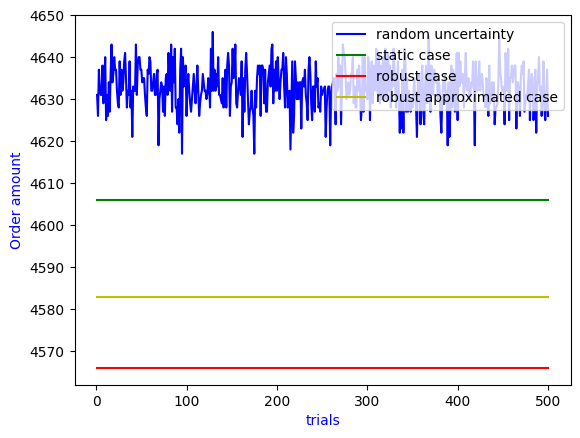

In [89]:
###############################################
## 参数控制求解&结果可视化
###############################################
Obj_values = []
test_count = 500 ## 测试次数
for i in range(test_count):
    current_uncertainty_1 = np.random.uniform(-Omega/2,Omega/2, size=cost.shape)
    # current_uncertainty_2 = np.random.uniform(-Omega/2,Omega/2, size=cost.shape)
    Cost.value = cost + np.multiply(cost_std,current_uncertainty_1)
    # Value.value = value + np.multiply(value_std, current_uncertainty_2)
    Value.value = value
    Budget.value = B
    # Value.value = value
    problem1.solve(solver=cp.MOSEK)
    if problem1.status == 'infeasible':
        Obj_values.append(0)
    else:
        Obj_values.append(problem1.value)
    # print('uncertainty_case_{}'.format(i))
    # for i in range(I):
    #     for r in range(R):
    #         if X[(i,r)].value == 1:
    #              print('第{}类骑手的智能活动策略为:门槛1为{}, 金额1为{}; 门槛2为{}, 金额2为{}; 门槛3为{}, 金额3为{}; 门槛4为{}, 金额4为{}'.format(i,threshold[i][0],reward_1_candidate[r],\
    #                    threshold[i][1],reward_1_candidate[r]+reward_delta[0], threshold[i][2],reward_1_candidate[r]+reward_delta[1],\
    #                     threshold[i][3],reward_1_candidate[r]+reward_delta[2]))
## static case
Budget.value = B
Cost.value = cost
Value.value = value
problem1.solve(solver=cp.MOSEK)
reference_obj = problem1.value
# print('static_case')
# for i in range(I):
#     for r in range(R):
#         if X[(i,r)].value == 1:
#             print('第{}类骑手的智能活动策略为:门槛1为{}, 金额1为{}; 门槛2为{}, 金额2为{}; 门槛3为{}, 金额3为{}; 门槛4为{}, 金额4为{}'.format(i,threshold[i][0],reward_1_candidate[r],\
#                     threshold[i][1],reward_1_candidate[r]+reward_delta[0], threshold[i][2],reward_1_candidate[r]+reward_delta[1],\
#                         threshold[i][3],reward_1_candidate[r]+reward_delta[2]))

## robust case
Budget.value = B
Cost.value = cost
Value.value = value
problem2.solve(solver=cp.MOSEK, verbose=True)
robust_obj = np.sum(np.multiply(X.value, value))
# robust_obj = problem2.value
# print('robust_case')
# for i in range(I): 
#     for r in range(R):
#         if X[(i,r)].value >= 0.99:
#             print('第{}类骑手的智能活动策略为:门槛1为{}, 金额1为{}; 门槛2为{}, 金额2为{}; 门槛3为{}, 金额3为{}; 门槛4为{}, 金额4为{}'.format(i,threshold[i][0],reward_1_candidate[r],\
#                     threshold[i][1],reward_1_candidate[r]+reward_delta[0], threshold[i][2],reward_1_candidate[r]+reward_delta[1],\
#                         threshold[i][3],reward_1_candidate[r]+reward_delta[2]))    

## robust approximated case
Budget.value = B
Cost.value = cost
Value.value = value
problem3.solve(solver=cp.MOSEK)
robust_approximated_obj = np.sum(np.multiply(X.value, value))
# robust_approximated_obj = problem3.value

## 画图
fig, ax1 = plt.subplots()

ax1.plot([_ for _ in range(1,test_count+1)], Obj_values, 'b-', label='random uncertainty')
ax1.plot([_ for _ in range(1,test_count+1)], [reference_obj for _ in range(1,test_count+1)], 'g-', label='static case')
ax1.plot([_ for _ in range(1,test_count+1)], [robust_obj for _ in range(1,test_count+1)], 'r-', label='robust case')
ax1.plot([_ for _ in range(1,test_count+1)], [robust_approximated_obj for _ in range(1,test_count+1)], 'y-', label='robust approximated case')
ax1.set_xlabel('trials', color='b')
ax1.set_ylabel('Order amount', color='b')
# ax1.tick_params(axis='Objective Value')

# roi = [Obj_values[i]/B_values[i] for i in range(len(Obj_values))]
# ax2 = ax1.twinx()
# ax2.plot(list(B_values), roi ,'r-', label='ROI')
# ax2.set_ylabel('ROI', color='r')
# ax2.tick_params(axis='ROI')

plt.legend()
plt.show()

In [29]:
print(reference_obj)
print(robust_obj)
print(robust_approximated_obj)
print((reference_obj-robust_obj)/reference_obj)
print((reference_obj-robust_approximated_obj)/reference_obj)

4606.0
4362.427778195997
4139.746105853424
0.052881507122015364
0.1012275063279584


                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 16 08:58:45 PM: Your problem has 101 variables, 3 constraints, and 1 parameters.
(CVXPY) Aug 16 08:58:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 16 08:58:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 16 08:58:45 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Aug 16 08:58:45 PM: Finished problem compilation (took 1.784e-03 seconds).
-------------------------------------------------------------------------------
                              

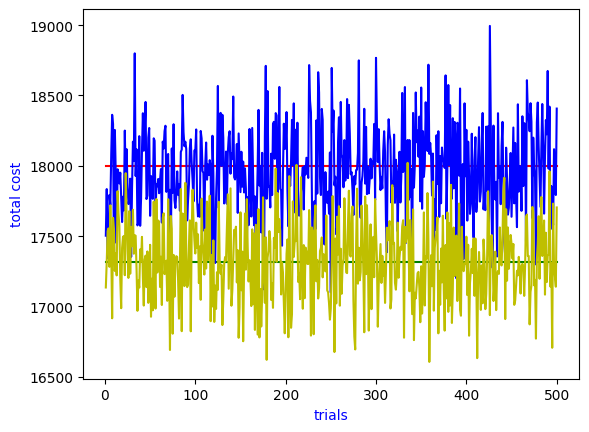

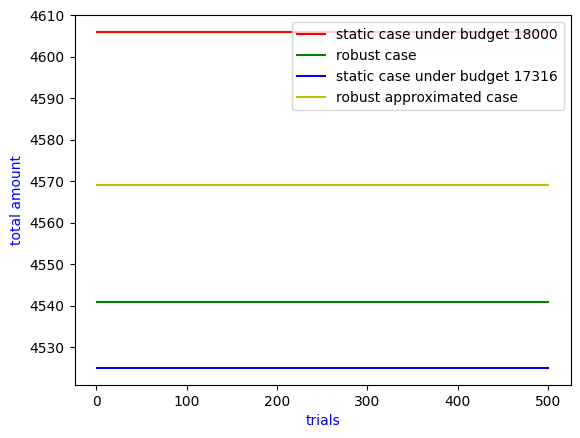

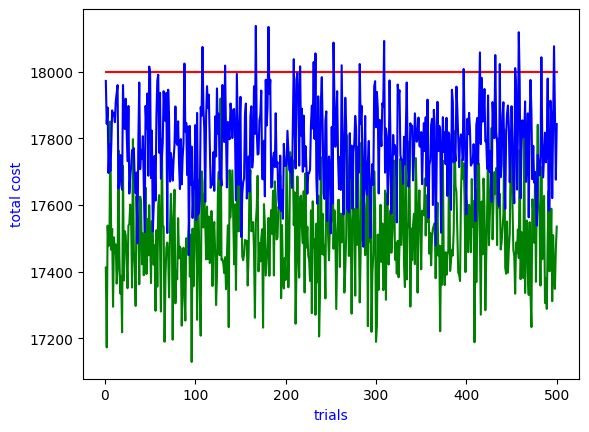

4606.0
4525.0
4541.0
4569.0
0.00803300043421624
0.01411202778983934
0.017585757707338254


In [110]:
##########################################
## 鲁棒优化效果进一步验证 
# 思路：
# Step1： 给定cost和value，求出optimal solution；然后随机扰动cost和value，把扰动后的cost和value带入optimal solution，看看是否满足budget constraint
# Step2: 把budget适当降低，求出当前的optimal solution，然后随机扰动cost和value，把扰动后的cost和value带入optimal solution，看看是否满足 intial budget
# Step3：把step2的optimal solution 和 robust solution进行对比，看谁的收益更高
##########################################
Budget.value = B
Cost.value = cost
Value.value = value
problem1.solve(solver=cp.MOSEK)
reference_obj_1 = problem1.value

budget_values_1 = []
test_count = 500 ## 测试次数
over_budget_count = 0 ## 超出budget的次数
for i in range(test_count):
    current_uncertainty_1 = np.random.uniform(-Omega,Omega, size=cost.shape)
    budget_value = np.sum(np.multiply(X.value,cost + np.multiply(cost_std,current_uncertainty_1)))
    budget_values_1.append(budget_value)
    if budget_value > B:
        over_budget_count += 1
    # Value.value = value

## 画图
# fig, ax1 = plt.subplots()
# ax1.plot([_ for _ in range(1,test_count+1)], [np.sum(np.multiply(X.value,cost)) for _ in range(1,test_count+1)], 'r-', label='budget')
# ax1.plot([_ for _ in range(1,test_count+1)], budget_values_1, 'b-', label='real total cost of optimal solution under cost uncertainty')
# ax1.set_xlabel('trials', color='b')
# ax1.set_ylabel('total cost', color='b')

# plt.legend()
# plt.show()
# print(over_budget_count)
percentage = 0.962
Budget.value = B*percentage
Cost.value = cost
Value.value = value
problem1.solve(solver=cp.MOSEK)
reference_obj_2 = problem1.value
budget_values_2 = []
for i in range(test_count):
    current_uncertainty_1 = np.random.uniform(-Omega,Omega, size=cost.shape)
    budget_value = np.sum(np.multiply(X.value,cost + np.multiply(cost_std,current_uncertainty_1)))
    budget_values_2.append(budget_value)
    
## robust case
Budget.value = B
Cost.value = cost
Value.value = value
problem2.solve(solver=cp.MOSEK, verbose=True)
robust_obj = np.sum(np.multiply(X.value,value))
# robust_obj = problem2.value
budget_values_3 = []
over_budget_count_3 = 0 ## 超出budget的次数
for i in range(test_count):
    current_uncertainty_1 = np.random.uniform(-Omega/2,Omega/2, size=cost.shape)
    budget_value = np.sum(np.multiply(X.value,cost + np.multiply(cost_std,current_uncertainty_1)))
    budget_values_3.append(budget_value)
    if budget_value > B:
        over_budget_count_3 += 1
print("鲁棒模型下参数波动导致超出预算的case有{}".format(over_budget_count_3))


## robust approximated case
Budget.value = B
Cost.value = cost
Value.value = value
problem3.solve(solver=cp.MOSEK)
robust_approximated_obj = np.sum(np.multiply(X.value, value))
# robust_approximated_obj = problem3.value
budget_values_4 = []
over_budget_count_4 = 0 ## 超出budget的次数
for i in range(test_count):
    current_uncertainty_1 = np.random.uniform(-Omega/2,Omega/2, size=cost.shape)
    budget_value = np.sum(np.multiply(X.value,cost + np.multiply(cost_std,current_uncertainty_1)))
    budget_values_4.append(budget_value)
    if budget_value > B:
        over_budget_count_4 += 1
print("鲁棒近似模型下参数波动导致超出预算的case有{}".format(over_budget_count_4))
## 画图
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,10))
fig, ax1 = plt.subplots()
ax1.plot([_ for _ in range(1,test_count+1)], [B for _ in range(1,test_count+1)], 'r-', label='budget')
ax1.plot([_ for _ in range(1,test_count+1)], [B*percentage for _ in range(1,test_count+1)], 'g-', label='{} of budget'.format(percentage))
ax1.plot([_ for _ in range(1,test_count+1)], budget_values_1, 'b-', label='cost uncertainty under budget {}'.format(B))
ax1.plot([_ for _ in range(1,test_count+1)], budget_values_2, 'y-', label='cost uncertainty under budget {}'.format(int(B*percentage)))
ax1.set_xlabel('trials', color='b')
ax1.set_ylabel('total cost', color='b')
plt.show()

fig, ax2 = plt.subplots()
ax2.plot([_ for _ in range(1,test_count+1)], [reference_obj_1 for _ in range(1,test_count+1)], 'r-', label='static case under budget {}'.format(B))
ax2.plot([_ for _ in range(1,test_count+1)], [robust_obj for _ in range(1,test_count+1)], 'g-', label='robust case')
ax2.plot([_ for _ in range(1,test_count+1)], [reference_obj_2 for _ in range(1,test_count+1)], 'b-', label='static case under budget {}'.format(int(B*percentage)))
ax2.plot([_ for _ in range(1,test_count+1)], [robust_approximated_obj for _ in range(1,test_count+1)], 'y-', label='robust approximated case')
ax2.set_xlabel('trials', color='b')
ax2.set_ylabel('total amount', color='b')
ax2.legend()
# plt.legend()
plt.show()

fig, ax3 = plt.subplots()
ax3.plot([_ for _ in range(1,test_count+1)], [B for _ in range(1,test_count+1)], 'r-', label='budget')
ax3.plot([_ for _ in range(1,test_count+1)], budget_values_3, 'g-', label='robust case')
ax3.plot([_ for _ in range(1,test_count+1)], budget_values_4, 'b-', label='robust approximated case')
ax3.set_xlabel('trials', color='b')
ax3.set_ylabel('total cost', color='b')
plt.show()


print(reference_obj_1)
print(reference_obj_2)
print(robust_obj)
print(robust_approximated_obj)
print((reference_obj_1 - robust_approximated_obj)/reference_obj_1)
print((reference_obj_1 - robust_obj)/reference_obj_1)
print((reference_obj_1 - reference_obj_2)/reference_obj_1)


In [7]:
##########################################
## 鲁棒优化求解: 二阶锥规划（向量x的2范数是x中各个元素平方之和再开根号）
##########################################
## 定义参数
Omega = 0.5 ## 椭圆不确定集的半径
## 定义变量
alpha = cp.Variable(1) ## 目标值
X = cp.Variable(cost.shape, boolean=True)
ones_1 = np.ones((cost.shape[1],1))
ones_2 = np.ones((cost.shape[0],1))

## 目标函数
obj = cp.Maximize(alpha)
# obj = cp.Maximize(cp.sum(cp.multiply(value, X)))

## 约束条件
constraints = []
constraints += [cp.SOC((cp.sum(cp.multiply(value, X))-alpha)/Omega, cp.vstack([value_std[i,r]*X[i,r] for i in range(cost.shape[0]) for r in range(cost.shape[1])]))]
constraints += [cp.SOC((B-cp.sum(cp.multiply(cost, X)))/Omega, cp.vstack([cost_std[i,r]*X[i,r] for i in range(cost.shape[0]) for r in range(cost.shape[1])]))]
constraints += [X@ones_1 == ones_2]

## 问题求解
problem = cp.Problem(obj, constraints)
problem.solve(solver=cp.MOSEK, verbose=True)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 11 05:29:03 PM: Your problem has 101 variables, 3 constraints, and 0 parameters.
(CVXPY) Aug 11 05:29:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 11 05:29:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 11 05:29:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 11 05:29:03 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Aug 11 05:29:03 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Co

4262.621520628922

In [8]:
problem.value

4262.621520628922